# Introduction


Ocular Disease Recognition dataset

* Normal (N);  
* Diabetes (D);  
* Glaucoma (G);  
* Cataract (C);  
* AMD (A);  
* Hypertension (H);  
* Myopia (M);
* Other diseases/abnormalities (O)  


This project focuses on Cataract.


# Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 50
NUM_CLASSES = 2
DATA_FOLDER = "/content/drive/MyDrive/Ocular Disease Recognition/ODIR-5K/Training Images"
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2 as cv
from random import shuffle
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
# import tensorflow_addons as tfa
import tensorflow as tf
%matplotlib inline

In [ ]:
data_df = pd.read_excel(open("/content/drive/MyDrive/Ocular Disease Recognition/ODIR-5K/data.xlsx", 'rb'), sheet_name='Sheet1')

In [ ]:
data_df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]

In [ ]:
print(data_df.loc[(data_df.cataract==1)].shape)
print(data_df.loc[data_df.cataract==0].shape)

(212, 15)
(3288, 15)


In [ ]:
data_df.loc[(data_df.cataract==1)]['left_diagnosys'].value_counts()

,count
left_diagnosys,
cataract,135
normal fundus,24
cataract，lens dust,8
moderate non proliferative retinopathy,6
lens dust，cataract,5
mild nonproliferative retinopathy,5
lens dust，normal fundus,4
cataract，moderate non proliferative retinopathy,3
refractive media opacity,3


In [ ]:
data_df.loc[(data_df.cataract==1)]['right_diagnosys'].value_counts()

,count
right_diagnosys,
cataract,127
normal fundus,24
moderate non proliferative retinopathy,9
cataract，lens dust,6
drusen,5
lens dust，cataract,5
mild nonproliferative retinopathy,4
refractive media opacity,4
macular epiretinal membrane,3


In [ ]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

In [ ]:
data_df['le_cataract'] = data_df['left_diagnosys'].apply(lambda x: has_cataract_mentioned(x))
data_df['re_cataract'] = data_df['right_diagnosys'].apply(lambda x: has_cataract_mentioned(x))

In [ ]:
cataract_le_list = data_df.loc[(data_df.cataract==1) & (data_df.le_cataract==1)]['left_fundus'].values
cataract_re_list = data_df.loc[(data_df.cataract==1) & (data_df.re_cataract==1)]['right_fundus'].values
print(len(cataract_le_list), len(cataract_re_list))
non_cataract_le_list = data_df.loc[(data_df.cataract==0) & (data_df.left_diagnosys=="normal fundus")]['left_fundus'].sample(150, random_state=314).values
non_cataract_re_list = data_df.loc[(data_df.cataract==0) & (data_df.right_diagnosys=="normal fundus")]['right_fundus'].sample(150, random_state=314).values
print(len(non_cataract_le_list), len(non_cataract_re_list))

159 154
150 150


In [ ]:
cataract_list = np.concatenate((cataract_le_list, cataract_re_list), axis = 0)
non_cataract_list = np.concatenate((non_cataract_le_list, non_cataract_re_list), axis = 0)
print(len(non_cataract_list), len(cataract_list))

300 313


In [ ]:
print(len(os.listdir(DATA_FOLDER)))

7010


In [ ]:
# def label_image(label):
#     if label == 1:
#         return [1,0]
#     elif label == 0:
#         return [0,1]

# def process_data(data_image_list, DATA_FOLDER, is_cataract):
#     data_df = []
#     for img in tqdm(data_image_list):
#         path = os.path.join(DATA_FOLDER,img)
#         label = label_image(is_cataract)
#         img = cv.imread(path,cv.IMREAD_COLOR)
#         img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
#         data_df.append([np.array(img),np.array(label)])
#     shuffle(data_df)
#     return data_df

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import os
import cv2 as cv
import numpy as np
from random import shuffle
from tqdm import tqdm

def label_image(label):
    if label == 1:
        return [1, 0]
    elif label == 0:
        return [0, 1]

def process_single_image(img, DATA_FOLDER, is_cataract):
    path = os.path.join(DATA_FOLDER, img)
    label = label_image(is_cataract)
    img = cv.imread(path, cv.IMREAD_COLOR)
    img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
    return [np.array(img), np.array(label)]

def process_data(data_image_list, DATA_FOLDER, is_cataract, num_workers=4):
    data_df = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_single_image, img, DATA_FOLDER, is_cataract) for img in data_image_list]
        for future in tqdm(futures):
            data_df.append(future.result())

    shuffle(data_df)
    return data_df


In [ ]:
len(non_cataract_list)

300

In [ ]:
cat_df = process_data(cataract_list, DATA_FOLDER, 1)
cat_no_df = process_data(non_cataract_list, DATA_FOLDER, 0)

100%|██████████| 313/313 [00:11<00:00, 27.66it/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(data, isTest=False):
    labels_map = ['Cataract', 'No Cataract']

    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    if isTest:
        str_label = 'None'

    for i, data_item in enumerate(data[:9]):
        img_data, img_label = data_item[0], data_item[1]

        if not isTest:
            label_index = np.argmax(img_label)
            str_label = labels_map[label_index]

        row, col = divmod(i, 3)

        axes[row, col].imshow(img_data)
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Label: {str_label}")

    plt.show()

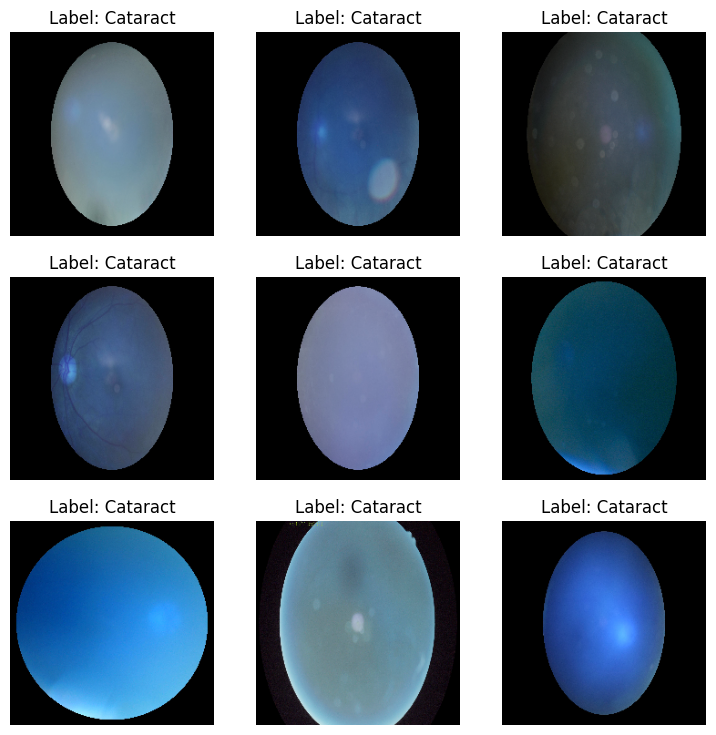

In [ ]:
show_images(cat_df)


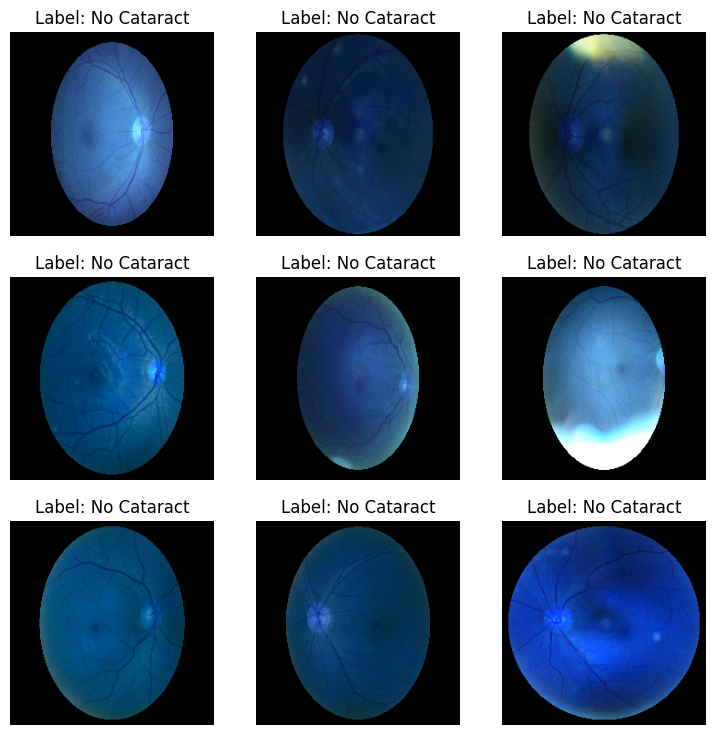

In [ ]:
show_images(cat_no_df)

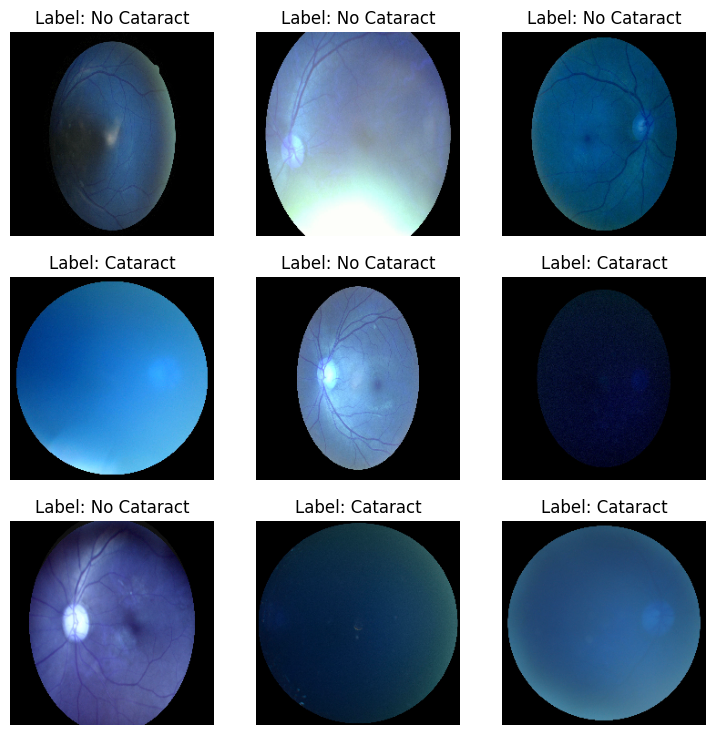

In [ ]:
train = cat_df + cat_no_df
shuffle(train)
show_images(train)

## Train Neural Network -- CNN

In [ ]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(2, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(f"Accuracy on test set: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.5013 - loss: 1.0969 - val_accuracy: 0.6098 - val_loss: 0.6820
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.5781 - loss: 0.6785 - val_accuracy: 0.6585 - val_loss: 0.6346
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.6091 - loss: 0.6684 - val_accuracy: 0.6748 - val_loss: 0.5872
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.6450 - loss: 0.6105 - val_accuracy: 0.6423 - val_loss: 0.6209
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.6694 - loss: 0.6108 - val_accuracy: 0.7317 - val_loss: 0.5606
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.6920 - loss: 0.5834 - val_accuracy: 0.7642 - val_loss: 0.5574
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.7222 - loss: 0.5401 - val_accuracy: 0.7886 - val_loss: 0.5329
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.7597 - loss: 0.5440 - val_accuracy: 0.7561 - val_loss

## Image Processing

In [ ]:
img_path = DATA_FOLDER + '/' + non_cataract_list[0]

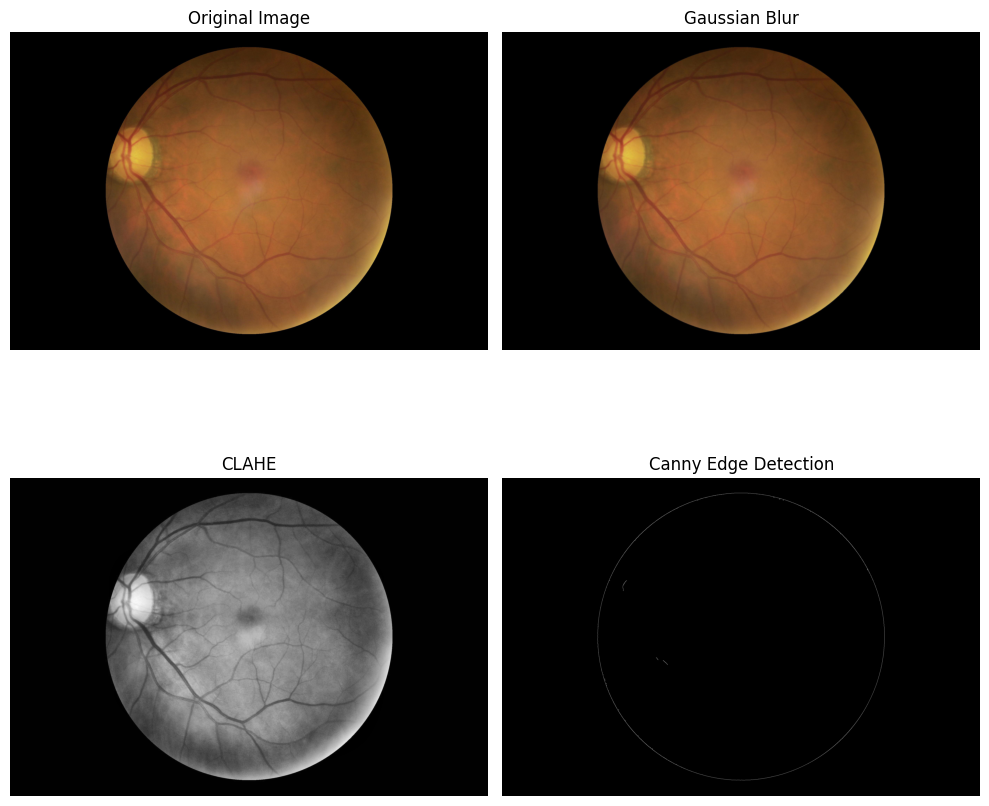

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img = cv.imread(img_path)

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# 1. Apply Gaussian Filter for noise reduction
gaussian_blur = cv.GaussianBlur(img, (5, 5), 0)

# 2. Apply CLAHE for contrast enhancement
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_applied = clahe.apply(gray)

# 3. Apply Canny Edge Detection for edge enhancement
edges = cv.Canny(clahe_applied, 100, 200)

# Visualize the results
plt.figure(figsize=(10,10))

# Original Image
plt.subplot(2,2,1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Gaussian Blur
plt.subplot(2,2,2)
plt.imshow(cv.cvtColor(gaussian_blur, cv.COLOR_BGR2RGB))
plt.title("Gaussian Blur")
plt.axis('off')

# CLAHE
plt.subplot(2,2,3)
plt.imshow(clahe_applied, cmap='gray')
plt.title("CLAHE")
plt.axis('off')

# Canny Edge Detection
plt.subplot(2,2,4)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')

plt.tight_layout()
plt.show()


## Improve Image Processing

In [ ]:
import os
import cv2 as cv
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from random import shuffle

IMG_SIZE = 224  # Assuming you have set a constant image size for resizing

def label_image(label):
    if label == 1:
        return [1, 0]
    elif label == 0:
        return [0, 1]

def enhance_image(img):
    # Convert image to grayscale for CLAHE and edge detection
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply Gaussian Filter for noise reduction
    img_filtered = cv.GaussianBlur(img, (5, 5), 0)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(gray)

    # Apply Edge Detection (Canny Edge Detector)
    edges = cv.Canny(img_filtered, 100, 200)

    # Convert the grayscale CLAHE-enhanced image back to 3 channels to match the CNN's input format
    img_clahe_3channel = cv.merge([img_clahe, img_clahe, img_clahe])

    # Stack the original image, CLAHE image, and edge detection results into a single 3-channel image
    img_combined = np.concatenate((img, img_clahe_3channel, cv.merge([edges, edges, edges])), axis=2)

    return img_combined

def improved_process_single_image(img, DATA_FOLDER, is_cataract):
    path = os.path.join(DATA_FOLDER, img)
    label = label_image(is_cataract)
    img = cv.imread(path, cv.IMREAD_COLOR)

    if img is None:
        print(f"Error: Image {img} not found in {DATA_FOLDER}")
        return None

    # Resize the image to match the expected CNN input size
    img = cv.resize(img, (IMG_SIZE, IMG_SIZE))

    # Enhance the image using the defined enhancement functions
    img_enhanced = enhance_image(img)

    return [np.array(img_enhanced), np.array(label)]

def improved_process_data(data_image_list, DATA_FOLDER, is_cataract, num_workers=4):
    data_df = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(improved_process_single_image, img, DATA_FOLDER, is_cataract) for img in data_image_list]
        for future in tqdm(futures):
            result = future.result()
            if result is not None:
                data_df.append(result)

    shuffle(data_df)
    return data_df


In [ ]:
cat_df = improved_process_data(cataract_list, DATA_FOLDER, 1)
cat_no_df = improved_process_data(non_cataract_list, DATA_FOLDER, 0)

100%|██████████| 300/300 [00:15<00:00, 19.63it/s]


In [ ]:
train = cat_df + cat_no_df
shuffle(train)

## Retrain CNN

# Train model

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# opt = tfa.optimizers.LazyAdam()
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025)
model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


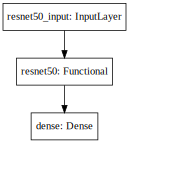

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

## Train model

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
16/16 [==============================] - 4s 255ms/step - loss: 32.5107 - accuracy: 0.5122 - val_loss: 45079.7734 - val_accuracy: 0.5122
Epoch 2/50
16/16 [==============================] - 3s 166ms/step - loss: 1.8105 - accuracy: 0.6510 - val_loss: 670.7700 - val_accuracy: 0.4878
Epoch 3/50
16/16 [==============================] - 3s 166ms/step - loss: 1.3222 - accuracy: 0.7367 - val_loss: 16.3940 - val_accuracy: 0.5122
Epoch 4/50
16/16 [==============================] - 3s 167ms/step - loss: 0.7933 - accuracy: 0.7653 - val_loss: 1.9896 - val_accuracy: 0.5041
Epoch 5/50
16/16 [==============================] - 3s 166ms/step - loss: 1.5170 - accuracy: 0.6898 - val_loss: 4.2199 - val_accuracy: 0.5122
Epoch 6/50
16/16 [==============================] - 3s 167ms/step - loss: 0.9909 - accuracy: 0.7306 - val_loss: 2.5222 - val_accuracy: 0.4878
Epoch 7/50
16/16 [==============================] - 3s 166ms/step - loss: 0.9353 - accuracy: 0.7959 - val_loss: 12.2400 - val_accuracy: 0.62

## Validation results

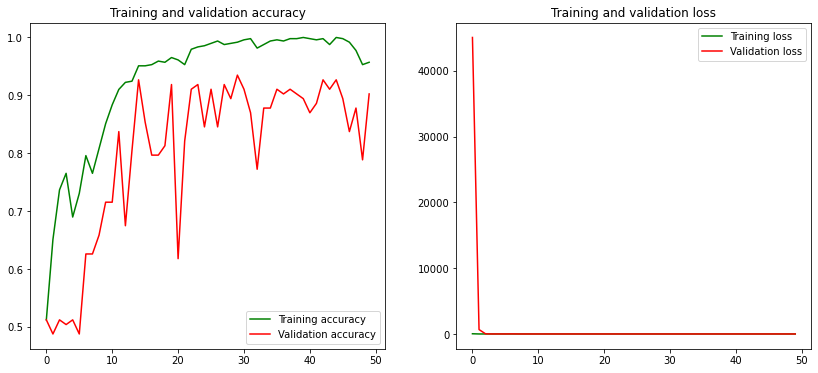

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.26654329895973206
Validation accuracy: 0.9024389982223511


In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

In [ ]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [ ]:
target_names = ["Cataract", "Normal"]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Cataract       0.93      0.87      0.90        63
      Normal       0.88      0.93      0.90        60

    accuracy                           0.90       123
   macro avg       0.90      0.90      0.90       123
weighted avg       0.90      0.90      0.90       123

